# LinRegProject

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import pickle
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
# Global Burden of Disease Collaborative Network. #
# Global Burden of Disease Study 2017 (GBD 2017) Results. #
# Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2018. #
# Available from http://ghdx.healthdata.org/gbd-results-tool. #
# Renamed to 'suicide_rates.csv' #
df1 = pd.read_csv('suicide_rates.csv') # 2005-2016, from Global Health Data Exchange from WHO

# Kaggle World Happiness dataset by user: Alcides Oxa #
df2 = pd.read_csv('world-happiness-report-2005-2018.csv', delimiter=';') # 2005-2018, from UN WHR

# Capitals from https://www.jasom.net/list-of-capital-cities-with-latitude-and-longitude/ #
df3 = pd.read_csv('capitals.csv')

# https://github.com/Botafogo1894/Project2/blob/master/mental_disorder_substance_use.csv #
df4 = pd.read_csv('mental_disorder_substance_use.csv') # 1990-2016

### 2005-2016 merge ###
### Target Variable: Suicide Rates ###

## Cleaning Data/Merging Data

In [3]:
### Use columns of countries, year, suicide rate ###
df1 = df1[['location_name', 'year', 'val']]
df1 = df1.rename({'location_name': 'country', 'val': 'suicide_rate'}, axis=1)
### Suicides/100,000 ###

### Order DataFrame entries by country then year ###
df1 = pd.DataFrame(df1.groupby(['country', 'year'])['suicide_rate'].sum()).reset_index()

### Round suicide_rate to 2 significant digits ###
df1['suicide_rate'] = round(df1['suicide_rate'], 2)

In [4]:
### Match column names for join ###
df2.rename({'Country name': 'country', 'Year': 'year'}, axis=1, inplace=True)
df4.rename({'Entity': 'country', 'Year': 'year'}, axis=1, inplace=True)

In [5]:
### Index for join ###
df1 = df1.groupby(['country', 'year']).sum()
df2 = df2.groupby(['country', 'year']).sum()
df4 = df4.groupby(['country', 'year']).sum()

In [6]:
### Join df1 and df2 ###
data = df1.join(df2)
data.dropna(inplace=True)
data = data.iloc[:, 0:8]

In [7]:
### Join data and df4 ###
data = data.join(df4)
data.dropna(inplace=True)

In [8]:
data.reset_index(inplace=True)

In [9]:
### Add mean log gdp for Syria to 2015 ###
data.loc[(data['country'] == 'Syria') & (data['year'] == 2015)] # Index: 1148
data.at[2014, 'Log GDP per capita'] = np.nan
data.groupby('country').mean().loc['Syria'] # Mean = 8.530000
data.at[1148, 'Log GDP per capita'] = 8.530000

In [10]:
### Drop Somalia, has no gdp values ###
data.loc[data['country'] == 'Somalia'] # Indices: 1069, 1070, 1071
data.drop([1069, 1070, 1071], inplace=True)

In [11]:
### Add GDP/capita column from log(gdp/capita) ###
data['gdp_cap'] = np.exp(data['Log GDP per capita'])

### Round to 2 significant digits ###
data = round(data, 2)

In [12]:
### Drop irrelevant columns ###
df3.drop(columns=['Capital'], inplace=True)

In [13]:
### Rename column for merge ###
df3.rename({'Country': 'country'}, axis=1, inplace=True)

In [14]:
### Merge df3 onto data ###
data = data.merge(df3, on='country')

In [15]:
### Replace whitespace in column names with underscore ###
col_names = { '{}'.format(x):'{}'.format(x.replace(' ', '_')) for x in data.columns }
data.rename(columns=col_names, inplace=True)
col_names = { '{}'.format(x):'{}'.format(x.replace('(%)', 'per')) for x in data.columns }
data.rename(columns=col_names, inplace=True)

## EDA/Feature Engineering

### EDA

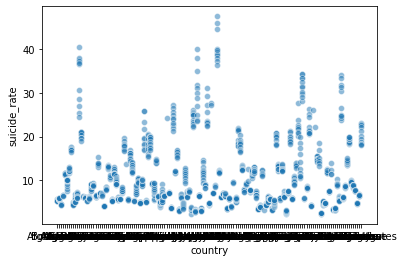

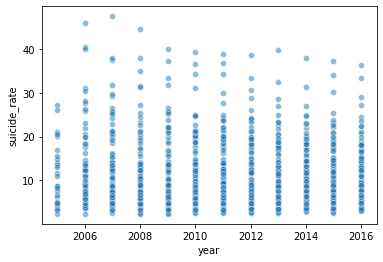

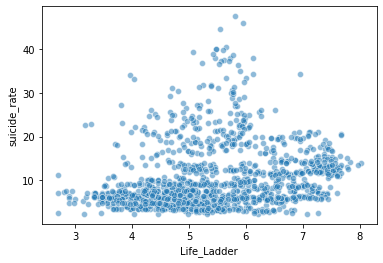

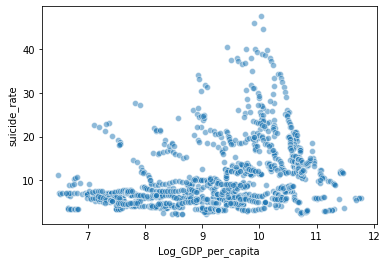

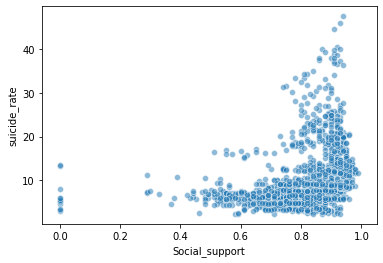

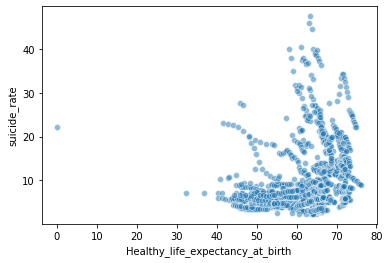

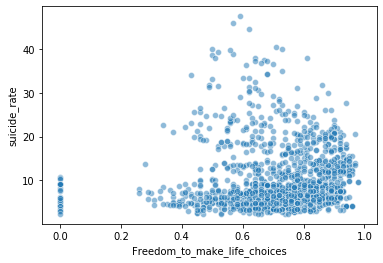

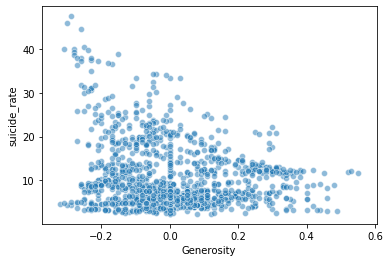

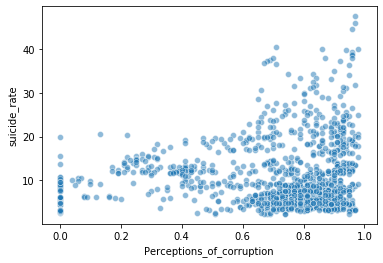

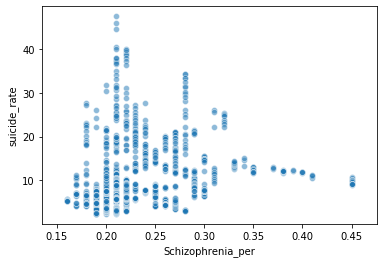

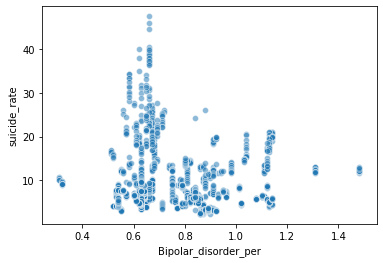

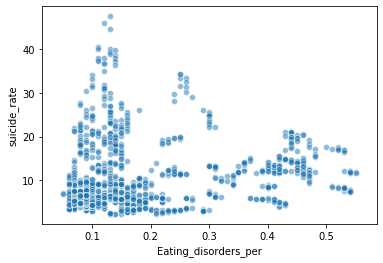

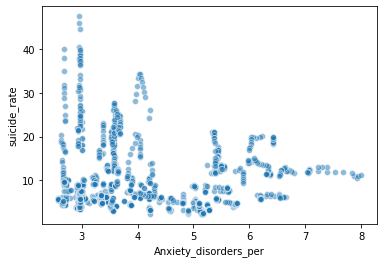

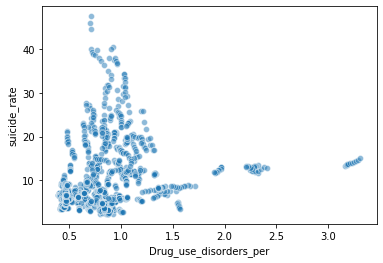

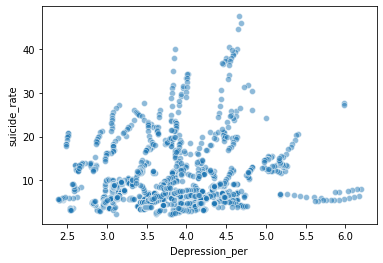

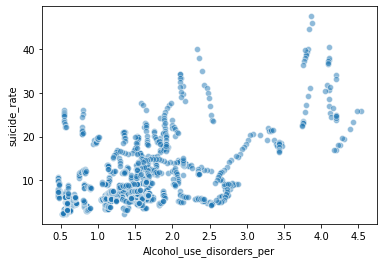

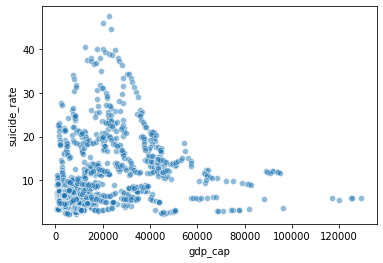

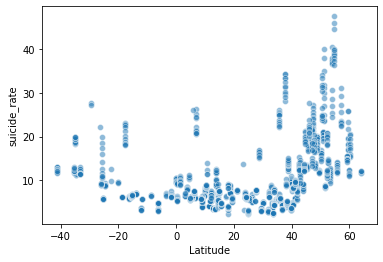

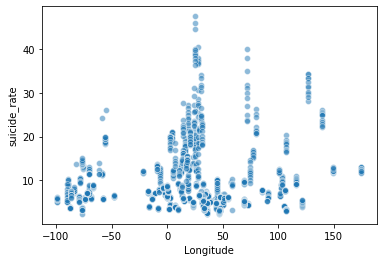

In [16]:
### EDA for Suicide Rate vs. Features ###
for feat in data.keys():
    if feat == 'suicide_rate':
        continue
    else:
        sns.scatterplot(data[feat], data['suicide_rate'], alpha=0.5)
        plt.show()

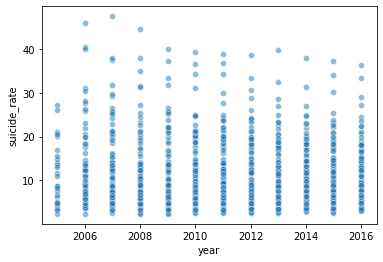

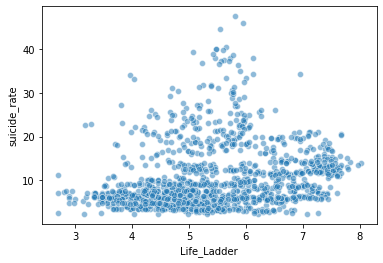

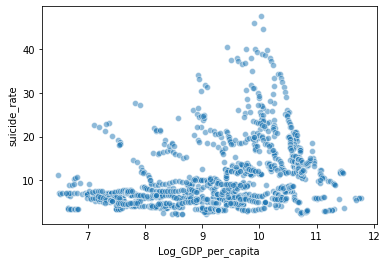

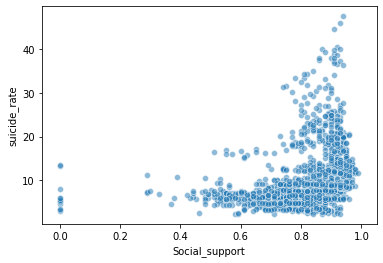

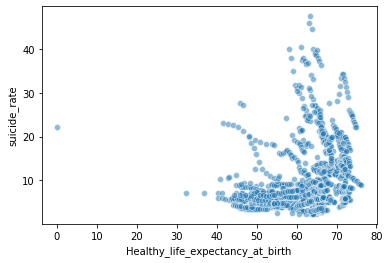

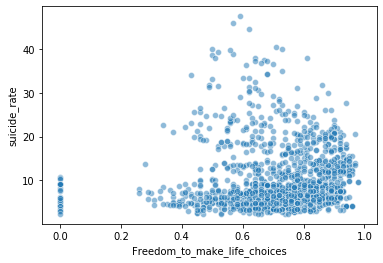

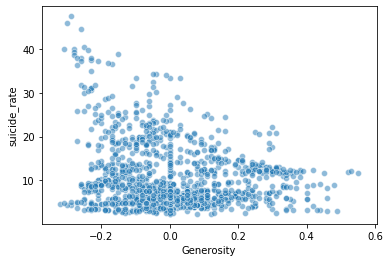

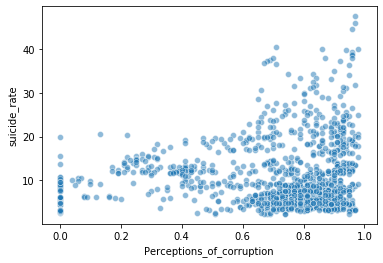

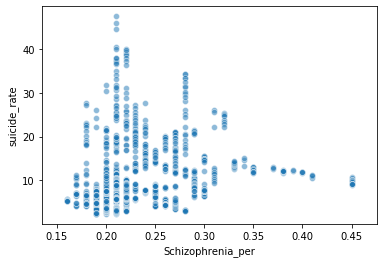

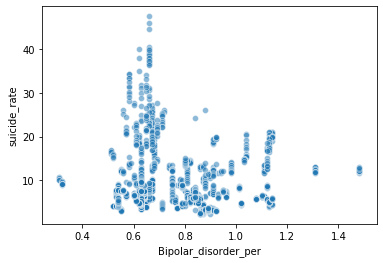

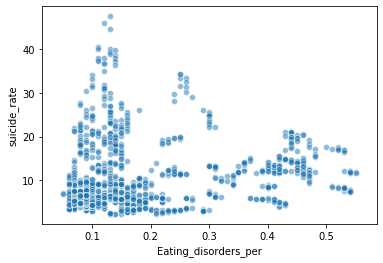

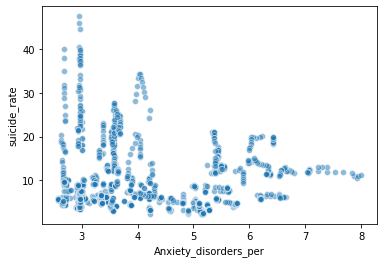

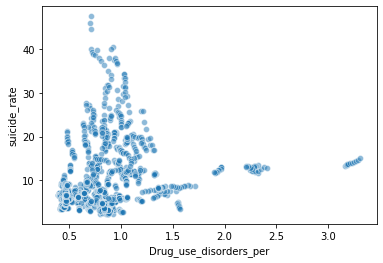

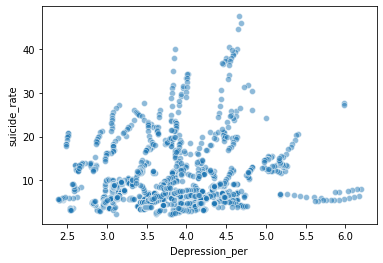

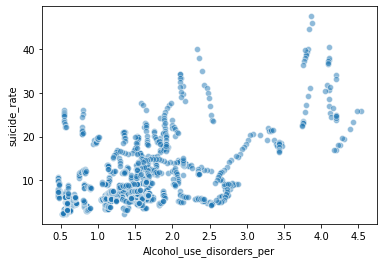

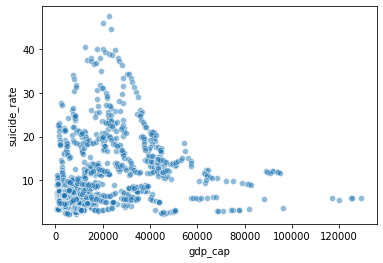

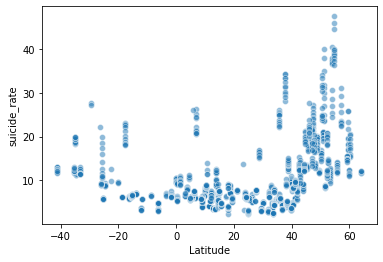

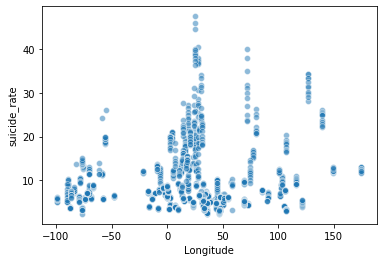

In [17]:
### EDA for Suicide Rate vs. transforming of Features ###
for feat in data.keys():
    if (feat == 'suicide_rate' or feat == 'country'):
        continue
    else:
        sns.scatterplot(data[feat], data['suicide_rate'], alpha=0.5)
        plt.show()

In [18]:
### Adding log tranformation of target variable ###
data['log_s_rate'] = np.log(data['suicide_rate'].values)

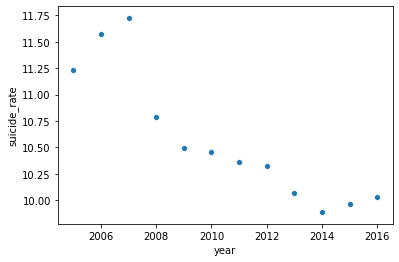

In [19]:
sns.scatterplot(data.groupby('year').mean().index, data.groupby('year')['suicide_rate'].mean())

In [20]:
### Create DataFrame of means values of target variable and features by country ###
data2 = data.copy()
data2 = data2.groupby('country').mean()

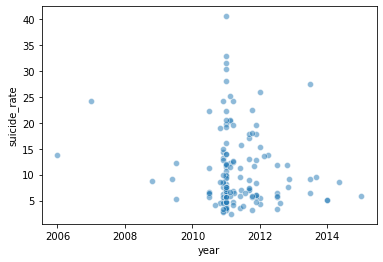

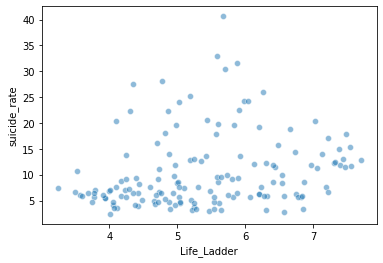

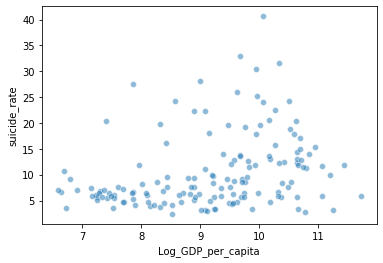

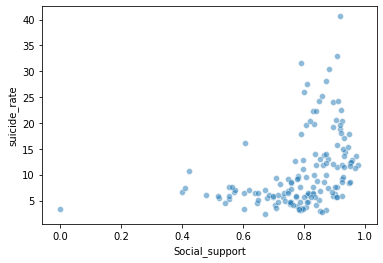

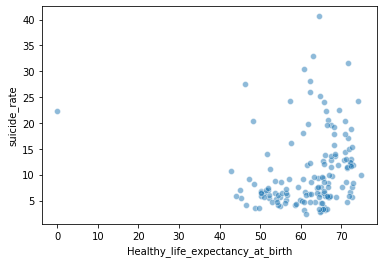

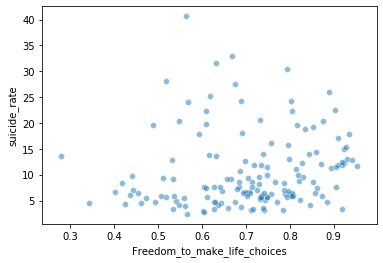

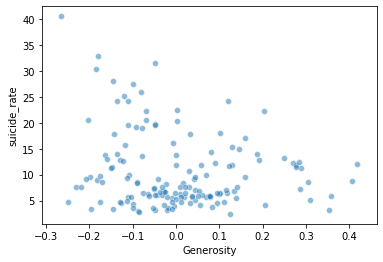

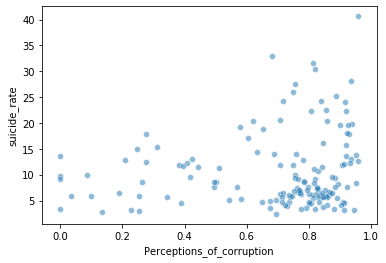

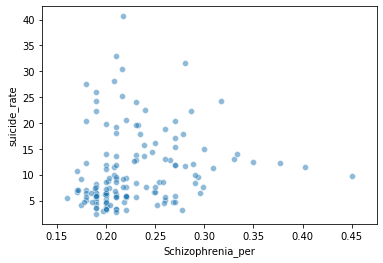

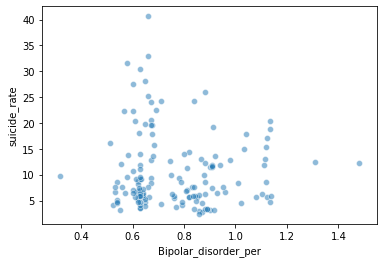

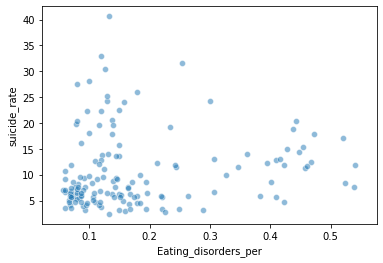

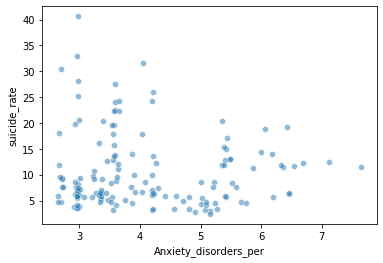

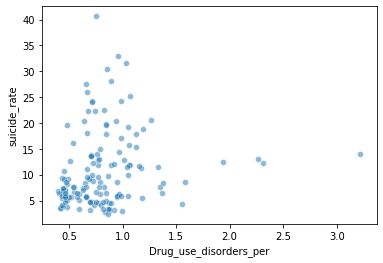

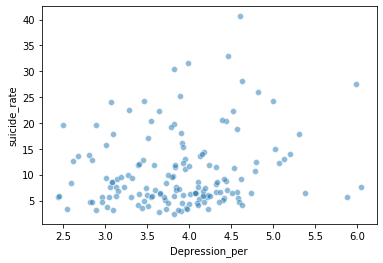

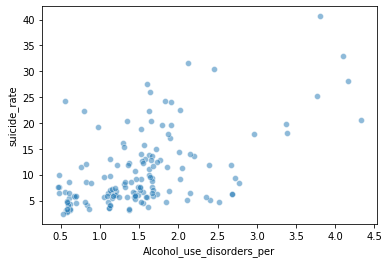

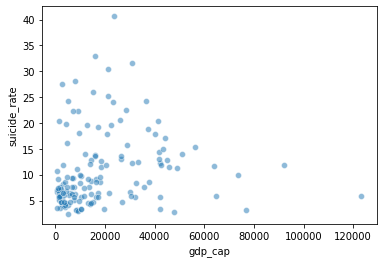

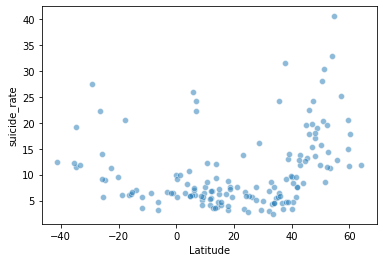

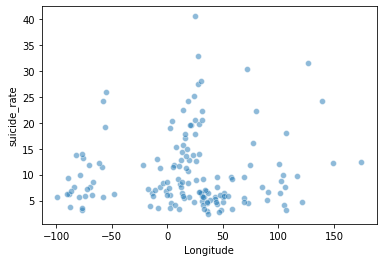

In [21]:
### Looking at means by country ###
for feat in data2.keys():
    if (feat == 'suicide_rate') or (feat == 'log_s_rate') or (feat == 'country'):
        continue
    else:
        sns.scatterplot(data2[feat], data2['suicide_rate'], alpha=0.5)
        plt.show()

In [22]:
data['lat_sq'] = data['Latitude'] ** 2

In [23]:
data['lat_abs'] = abs(data['Latitude'])

In [25]:
data.describe()

,year,suicide_rate,Life_Ladder,Log_GDP_per_capita,Social_support,Healthy_life_expectancy_at_birth,Freedom_to_make_life_choices,Generosity,Perceptions_of_corruption,Schizophrenia_per,Bipolar_disorder_per,Eating_disorders_per,Anxiety_disorders_per,Drug_use_disorders_per,Depression_per,Alcohol_use_disorders_per,gdp_cap,Latitude,Longitude,log_s_rate,lat_sq,lat_abs
count,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000
mean,2011.257724,10.459058,5.455154,9.219367,0.805622,62.914213,0.713044,0.003173,0.711839,0.229819,0.764544,0.183127,4.071191,0.818282,3.818365,1.546428,18047.775991,22.417609,18.684817,2.149958,1128.531145,29.020378
std,3.161307,7.274178,1.140750,1.184833,0.142988,7.850546,0.176382,0.156775,0.252506,0.047852,0.189800,0.129502,1.204418,0.401533,0.690058,0.796100,18615.278275,25.029064,56.819533,0.613369,1018.333628,16.928224
min,2005.000000,2.310000,2.690000,6.470000,0.000000,0.000000,0.000000,-0.320000,0.000000,0.160000,0.310000,0.050000,2.570000,0.390000,2.380000,0.460000,642.870000,-41.286460,-99.133208,0.837248,0.032636,0.180653
25%,2009.000000,5.645000,4.610000,8.290000,0.750000,58.310000,0.620000,-0.100000,0.670000,0.200000,0.630000,0.090000,2.990000,0.540000,3.320000,1.100000,3976.975000,6.847675,-3.703790,1.730770,189.236643,13.756331
50%,2011.000000,7.660000,5.350000,9.410000,0.840000,65.000000,0.740000,-0.010000,0.800000,0.210000,0.680000,0.140000,3.590000,0.750000,3.840000,1.480000,12235.370000,26.228516,23.321868,2.036012,1021.222877,31.956578
75%,2014.000000,13.115000,6.330000,10.200000,0.910000,68.200000,0.840000,0.090000,0.880000,0.250000,0.880000,0.230000,5.090000,0.960000,4.230000,1.815000,26868.920000,42.430420,45.864967,2.573756,1800.340541,42.430420
max,2016.000000,47.500000,8.020000,11.770000,0.990000,76.200000,0.980000,0.550000,0.980000,0.450000,1.480000,0.550000,7.990000,3.310000,6.190000,4.530000,129349.860000,64.126521,174.776236,3.860730,4112.210696,64.126521


In [28]:
### Features and target variables ###
features = data.drop(['suicide_rate', 'log_s_rate', 'country', 'year', 'lat_abs'], axis=1)
target1 = data['suicide_rate']
target2 = data['log_s_rate']

### Statistical Tests

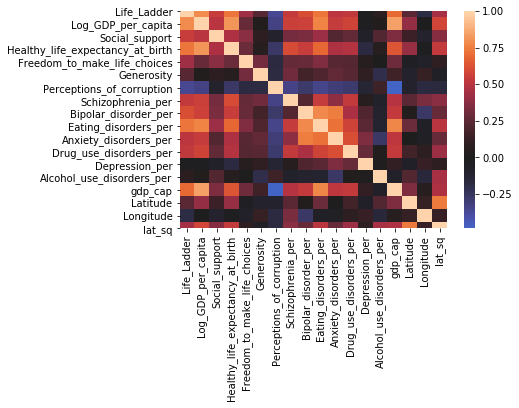

In [29]:
### Heatmap of correlation between features ###
sns.heatmap(features.corr(), center=0)
plt.show()

In [24]:
data.corr()

,year,suicide_rate,Life_Ladder,Log_GDP_per_capita,Social_support,Healthy_life_expectancy_at_birth,Freedom_to_make_life_choices,Generosity,Perceptions_of_corruption,Schizophrenia_per,Bipolar_disorder_per,Eating_disorders_per,Anxiety_disorders_per,Drug_use_disorders_per,Depression_per,Alcohol_use_disorders_per,gdp_cap,Latitude,Longitude,log_s_rate,lat_sq,lat_abs
year,1.000000,-0.068554,-0.023667,0.057537,-0.035390,0.115193,0.077090,-0.013246,-0.066642,-0.000041,0.009158,0.039864,0.006955,0.001413,-0.011685,-0.002586,0.051464,0.025692,0.007692,-0.043582,0.020527,0.022070
suicide_rate,-0.068554,1.000000,0.205590,0.327994,0.317670,0.240884,0.070950,-0.190471,0.099392,0.210042,-0.049135,0.145251,-0.049692,0.216951,0.126622,0.575960,0.208544,0.338519,0.141087,0.938141,0.584151,0.532409
Life_Ladder,-0.023667,0.205590,1.000000,0.787890,0.552553,0.727703,0.436594,0.236668,-0.360779,0.534577,0.611158,0.728035,0.508716,0.525702,-0.019856,0.072764,0.701791,0.239917,-0.178716,0.273503,0.447212,0.434866
Log_GDP_per_capita,0.057537,0.327994,0.787890,1.000000,0.501190,0.814974,0.280928,0.026186,-0.329910,0.558681,0.569979,0.763403,0.539920,0.575525,-0.029588,0.035484,0.847378,0.401797,-0.001972,0.355340,0.581458,0.586119
Social_support,-0.035390,0.317670,0.552553,0.501190,1.000000,0.466146,0.379122,0.088345,-0.094483,0.324542,0.338560,0.430572,0.221799,0.273026,-0.081687,0.217091,0.345893,0.145940,-0.099165,0.349200,0.369508,0.338263
Healthy_life_expectancy_at_birth,0.115193,0.240884,0.727703,0.814974,0.466146,1.000000,0.296739,0.057264,-0.269007,0.602243,0.547337,0.686521,0.466986,0.487474,-0.171997,0.062009,0.631627,0.408657,-0.024445,0.292700,0.531119,0.543711
Freedom_to_make_life_choices,0.077090,0.070950,0.436594,0.280928,0.379122,0.296739,1.000000,0.317173,-0.163954,0.278972,0.287471,0.351977,0.237318,0.230494,0.059102,-0.014303,0.300070,-0.046105,-0.078828,0.152526,0.099804,0.043172
Generosity,-0.013246,-0.190471,0.236668,0.026186,0.088345,0.057264,0.317173,1.000000,-0.175103,0.312298,0.165433,0.213026,0.272957,0.234316,0.096973,-0.196856,0.160467,-0.094601,0.117774,-0.108785,-0.063576,-0.090558
Perceptions_of_corruption,-0.066642,0.099392,-0.360779,-0.329910,-0.094483,-0.269007,-0.163954,-0.175103,1.000000,-0.340683,-0.271575,-0.346781,-0.302159,-0.287036,-0.128043,0.154115,-0.486139,-0.094158,-0.162755,0.064380,-0.157206,-0.159311
Schizophrenia_per,-0.000041,0.210042,0.534577,0.558681,0.324542,0.602243,0.278972,0.312298,-0.340683,1.000000,0.223900,0.542089,0.388072,0.534290,0.055890,-0.089894,0.497450,0.250828,0.341739,0.296448,0.377213,0.376676


Log of GDP/Capita is correlated with Life Ladder (Cantril Ladder, self-reported happiness in life from 1-10) and several other "happiness" metrics while mental disorders are often correlated with each other.

In [251]:
### Mean Suicide Rates of all countries ###
print(data['suicide_rate'].mean())
print(data['suicide_rate'].std())

10.459058025621703
7.27417841310068


In [246]:
### Create Not Tropics and Tropics categories ###
not_tropics = data.loc[abs(data['Latitude']) >= 23.26]['suicide_rate'] # Latitude as absolute values
tropics = data.loc[abs(data['Latitude']) < 23.26]['suicide_rate'] # Latitude as absolute values

In [249]:
### 2 Sample T-Test of Tropical vs. Non-tropical suicide rates ###
t_stat, p_value = stats.ttest_ind(not_tropics, tropics)
print('T-Statistic: ', t_stat)
print('p-value: ', p_value)

T-Statistic:  14.72336958200439
p-value:  1.4736551158040186e-45


The p-value is well under any significant value of alpha.  Null hypothesis that tropical suicide rates and non-tropical suicide rates is rejected.  This warrants further testing of latitude (geo-distance from equator) as an explanatory variable of suicide rates.

## Feature and Model Selection

In [26]:
### Import modules ###
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from itertools import combinations

In [30]:
### Create train-test split ###
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=34, test_size=0.2)

### Log of suicide rate is target variable ###

In [31]:
### Scale the data by training set and testing set ###
Sscaler = StandardScaler()
Mscaler = MinMaxScaler()
Rscaler = RobustScaler()

Mscaler.fit(X_train)
X_train = pd.DataFrame(data=Mscaler.transform(X_train), columns=features.columns)
X_test = pd.DataFrame(data=Mscaler.transform(X_test), columns=features.columns)

In [32]:
### Create list of interactions ###
interactions = list(combinations(features.columns, 2)) # From itertools.combinations

### Test R-Squared values of interactions ###
inter_feat = []
for i in interactions:
    X_int = pd.DataFrame(X_train[i[0]] * X_train[i[1]])
    model = LinearRegression()
    model.fit(X_int, y_train)
    y_train_pred = model.predict(X_int)
    train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
    if train_r_sq > 0.1:
        inter_feat.append(i)
        print(i,': {}'.format(train_r_sq))

('Life_Ladder', 'Alcohol_use_disorders_per') : 0.2869343588015305
('Life_Ladder', 'lat_sq') : 0.1216140051974971
('Log_GDP_per_capita', 'Alcohol_use_disorders_per') : 0.4009618997574975
('Log_GDP_per_capita', 'Latitude') : 0.11172396368069237
('Log_GDP_per_capita', 'lat_sq') : 0.22078933321333616
('Social_support', 'Alcohol_use_disorders_per') : 0.376695566073211
('Social_support', 'Latitude') : 0.1510419385480165
('Social_support', 'lat_sq') : 0.30488012661432073
('Healthy_life_expectancy_at_birth', 'Alcohol_use_disorders_per') : 0.34696068667600577
('Healthy_life_expectancy_at_birth', 'lat_sq') : 0.22223499012811188
('Freedom_to_make_life_choices', 'Alcohol_use_disorders_per') : 0.26729942552830877
('Freedom_to_make_life_choices', 'lat_sq') : 0.18155322972529075
('Perceptions_of_corruption', 'Alcohol_use_disorders_per') : 0.3215394188350702
('Perceptions_of_corruption', 'lat_sq') : 0.4031127485259396
('Schizophrenia_per', 'Alcohol_use_disorders_per') : 0.2035074322257463
('Bipolar_di

In [33]:
### Add interactions columns of relevant columns ###
for feats in inter_feat:
    features['{}_and_{}'.format(feats[0], feats[1])] = features[feats[0]] * features[feats[1]]

### Wrapper Method

In [172]:
### Create new train-test split with added interactions features ###
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=34, test_size=0.2)

### Log of suicide rate is target variable ###

In [173]:
### Scale the data by training set and testing set ###
Sscaler = StandardScaler()
Mscaler = MinMaxScaler()
Rscaler = RobustScaler()

Mscaler.fit(X_train)
X_train = pd.DataFrame(data=Mscaler.transform(X_train), columns=features.columns)
X_test = pd.DataFrame(data=Mscaler.transform(X_test), columns=features.columns)

In [174]:
### Instantiate linear regression object ###
lin_reg = LinearRegression() # Must have a fit() method

In [175]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=lin_reg, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]

In [176]:
### Removed features ###
print('Selected:', list(selected_columns))
print(len(selected_columns))
print('Removed:', removed_columns)

Selected: ['Life_Ladder', 'Log_GDP_per_capita', 'Social_support', 'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices', 'Generosity', 'Perceptions_of_corruption', 'Schizophrenia_per', 'Bipolar_disorder_per', 'Eating_disorders_per', 'Anxiety_disorders_per', 'Drug_use_disorders_per', 'Depression_per', 'Alcohol_use_disorders_per', 'gdp_cap', 'Latitude', 'Longitude', 'lat_sq', 'Life_Ladder_and_Alcohol_use_disorders_per', 'Life_Ladder_and_lat_sq', 'Log_GDP_per_capita_and_Alcohol_use_disorders_per', 'Log_GDP_per_capita_and_Latitude', 'Log_GDP_per_capita_and_lat_sq', 'Social_support_and_Alcohol_use_disorders_per', 'Social_support_and_Latitude', 'Social_support_and_lat_sq', 'Healthy_life_expectancy_at_birth_and_Alcohol_use_disorders_per', 'Healthy_life_expectancy_at_birth_and_lat_sq', 'Freedom_to_make_life_choices_and_Alcohol_use_disorders_per', 'Freedom_to_make_life_choices_and_lat_sq', 'Perceptions_of_corruption_and_Alcohol_use_disorders_per', 'Perceptions_of_corruption_and_lat

In [177]:
### Check RMSE of prelim model ###
lin_reg.fit(X_train, y_train)
y_train_pred = lin_reg.predict(X_train)
y_pred = lin_reg.predict(X_test)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )
print('Training R-Squared: '+ str(train_r_sq) )
print('Testing R-Squared: '+ str(test_r_sq) )

Training Error: 2.787609920047082
Testing Error: 4.220969401430606
Training R-Squared: 0.6860612400911961
Testing R-Squared: 0.6258134740978362


In [178]:
### Check RMSE of prelim - removed columns model ###
X_train_minus = X_train.drop(columns=removed_columns) # Create new train set minus removed cols
X_test_minus = X_test.drop(columns=removed_columns) # Create new test set minus removed cols

lin_reg.fit(X_train_minus, y_train)
y_train_pred = lin_reg.predict(X_train_minus)
y_pred = lin_reg.predict(X_test_minus)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_pred))
print('RC Training Error: '+ str(train_rmse) )
print('RC Testing Error: '+ str(test_rmse) )
print('RC Training R-Squared: '+ str(train_r_sq) )
print('RC Testing R-Squared: '+ str(test_r_sq) )

RC Training Error: 2.7875342725067354
RC Testing Error: 4.222319115563155
RC Training R-Squared: 0.6860697898489686
RC Testing R-Squared: 0.6255741330641711


Most combinations of features has resulted in lower RMSE and higher R^2 values with the Linear Regression model using Recursive Feature Elimination compared to the standard Linear Regression model.

### Ridge and Lasso

In [185]:
### Check RMSE of Lasso and Ridge ###
lasso = Lasso(alpha=0.001, normalize=False)
ridge = Ridge(alpha=0.005, normalize=False)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
y_r_train_pred = ridge.predict(X_train)
y_r_pred = ridge.predict(X_test)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_pred))
print('Lasso Training Error: '+ str(train_rmse) )
print('Lasso Testing Error: '+ str(test_rmse) )
print('-------------------')
print('Lasso Training R-Squared: '+ str(train_r_sq) )
print('Lasso Testing R-Squared: '+ str(test_r_sq) )
print('--------------------------------------------')

r_train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_r_train_pred))
r_test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_r_pred)))
r_train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_r_train_pred))
r_test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_r_pred))
print('Ridge Training Error: '+ str(r_train_rmse) )
print('Ridge Testing Error: '+ str(r_test_rmse) )
print('-------------------')
print('Ridge Training R-Squared: '+ str(r_train_r_sq) )
print('Ridge Testing R-Squared: '+ str(r_test_r_sq) )

Lasso Training Error: 3.0304841129944498
Lasso Testing Error: 4.973023061584551
-------------------
Lasso Training R-Squared: 0.5900860831519381
Lasso Testing R-Squared: 0.4805967251270561
--------------------------------------------
Ridge Training Error: 2.7852447768253183
Ridge Testing Error: 4.199867476467577
-------------------
Ridge Training R-Squared: 0.6861948827605291
Ridge Testing R-Squared: 0.6295454692088222


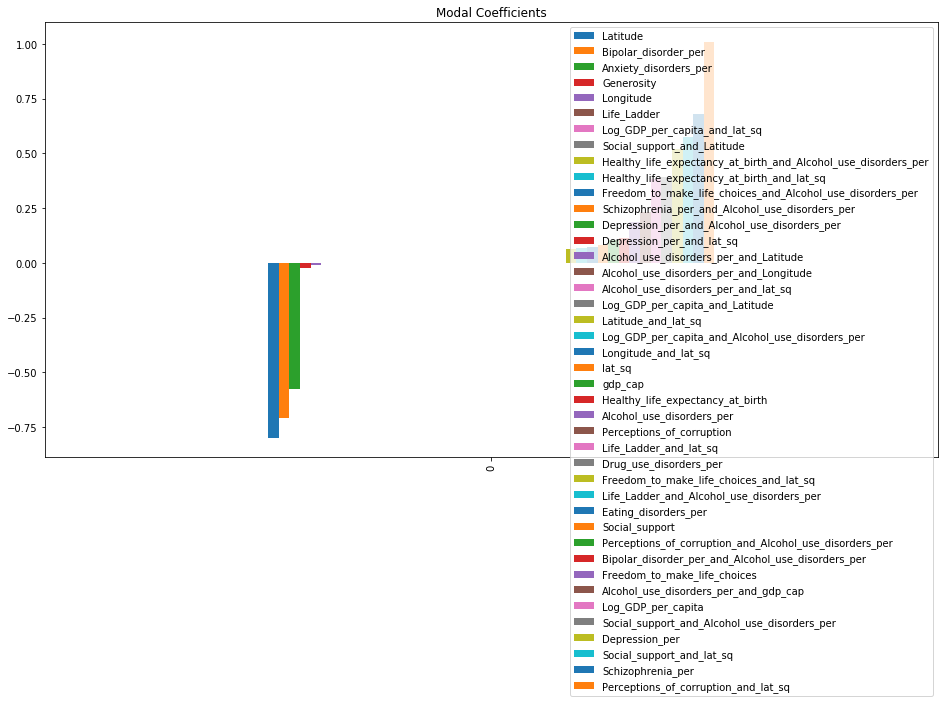

In [186]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,8))

In [187]:
### Check RMSE of Lasso - removed_columns and Ridge - removed_columns ###
lasso = Lasso(alpha=0.001, normalize=False)
ridge = Ridge(alpha=0.005, normalize=False)

ridge.fit(X_train_minus, y_train)
lasso.fit(X_train_minus, y_train)

y_train_pred = lasso.predict(X_train_minus)
y_pred = lasso.predict(X_test_minus)
y_r_train_pred = ridge.predict(X_train_minus)
y_r_pred = ridge.predict(X_test_minus)

train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_train_pred))
test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_pred))
print('Lasso Training Error: '+ str(train_rmse) )
print('Lasso Testing Error: '+ str(test_rmse) )
print('-------------------')
print('Lasso Training R-Squared: '+ str(train_r_sq) )
print('Lasso Testing R-Squared: '+ str(test_r_sq) )
print('--------------------------------------------')

r_train_rmse = metrics.mean_absolute_error(np.exp(y_train), np.exp(y_r_train_pred))
r_test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_r_pred)))
r_train_r_sq = metrics.r2_score(np.exp(y_train), np.exp(y_r_train_pred))
r_test_r_sq = metrics.r2_score(np.exp(y_test), np.exp(y_r_pred))
print('Ridge Training Error: '+ str(r_train_rmse) )
print('Ridge Testing Error: '+ str(r_test_rmse) )
print('-------------------')
print('Ridge Training R-Squared: '+ str(r_train_r_sq) )
print('Ridge Testing R-Squared: '+ str(r_test_r_sq) )

Lasso Training Error: 3.0304840646023377
Lasso Testing Error: 4.973022993683021
-------------------
Lasso Training R-Squared: 0.5900861026683675
Lasso Testing R-Squared: 0.4805967393108942
--------------------------------------------
Ridge Training Error: 2.7837746004378965
Ridge Testing Error: 4.21125704051423
-------------------
Ridge Training R-Squared: 0.6862377516475853
Ridge Testing R-Squared: 0.62753348345876


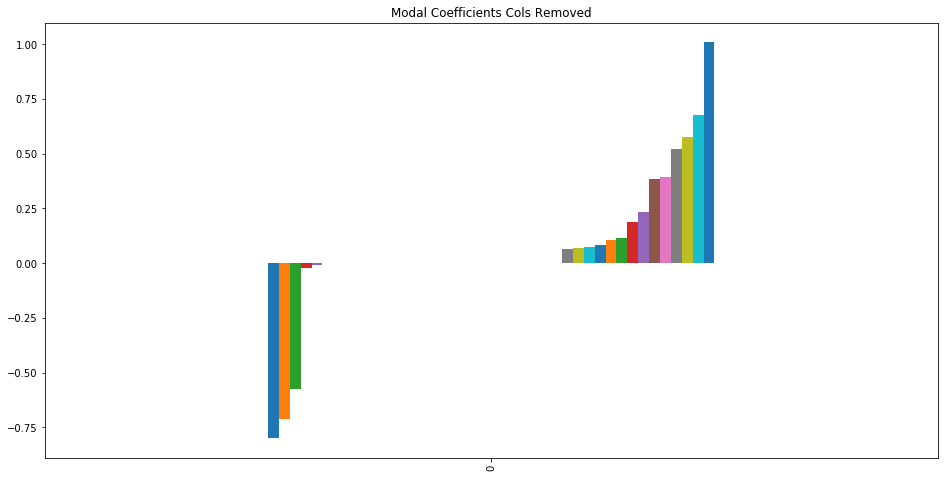

In [188]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train_minus.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients Cols Removed', legend=False, figsize=(16,8))

In [183]:
### Run GridSearch for hyperparameter tuning ###
alpha_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100]
param_grid = dict(alpha=alpha_range)

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, param_grid, cv=100, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=False)
ridge_grid.fit(X_train, y_train)
ridge_gs = pd.DataFrame(ridge_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(ridge_grid.best_score_)
print(ridge_grid.best_params_)
print(ridge_grid.best_estimator_)

lasso = Lasso()
lasso_grid = GridSearchCV(lasso, param_grid, cv=100, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=False)
lasso_grid.fit(X_train, y_train)
lasso_gs = pd.DataFrame(lasso_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(lasso_grid.best_score_)
print(lasso_grid.best_params_)
print(lasso_grid.best_estimator_)

-0.12990994494756553
{'alpha': 0.005}
Ridge(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
-0.15036840526356066
{'alpha': 0.001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [184]:
### Run GridSearch for hyperparameter tuning with Wrapper features removed ###
alpha_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100]
param_grid = dict(alpha=alpha_range)

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, param_grid, cv=100, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=False)
ridge_grid.fit(X_train_minus, y_train)
ridge_gs = pd.DataFrame(ridge_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(ridge_grid.best_score_)
print(ridge_grid.best_params_)
print(ridge_grid.best_estimator_)

lasso = Lasso()
lasso_grid = GridSearchCV(lasso, param_grid, cv=100, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=False)
lasso_grid.fit(X_train_minus, y_train)
lasso_gs = pd.DataFrame(lasso_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(lasso_grid.best_score_)
print(lasso_grid.best_params_)
print(lasso_grid.best_estimator_)

-0.1295949509654622
{'alpha': 0.005}
Ridge(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
-0.1503643098545559
{'alpha': 0.001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


The Ridge Regression model has generally been the top performing model with different feature combinations, with or without Recursive Feature Elimination, and with or without GridSearch hyperparameter tuning.  Final R^2: 0.628 on testing data set.

## Visualizations

In [102]:
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
import json

In [235]:
### Create Alcohol and Interactions DataFrame ###
alk_df = pd.DataFrame(target1)
for feats in inter_feat:
    alk_df['{}_and_{}'.format(feats[0], feats[1])] = features[feats[0]] * features[feats[1]]

In [219]:
### Create Alcohol and Interactions DataFrame ###
alk_df = pd.DataFrame(target1).join(features)

In [220]:
### Separate DataFrame for plotting ###
alk_df = alk_df[['suicide_rate', 'Life_Ladder_and_Alcohol_use_disorders_per',
                 'Social_support_and_Alcohol_use_disorders_per', 'Alcohol_use_disorders_per',
                 'Healthy_life_expectancy_at_birth_and_Alcohol_use_disorders_per',
                 'Freedom_to_make_life_choices_and_Alcohol_use_disorders_per',
                 'Perceptions_of_corruption_and_Alcohol_use_disorders_per',
                 'Schizophrenia_per_and_Alcohol_use_disorders_per',
                 'Bipolar_disorder_per_and_Alcohol_use_disorders_per',
                 'Depression_per_and_Alcohol_use_disorders_per',
                 'Log_GDP_per_capita_and_Alcohol_use_disorders_per', 'Alcohol_use_disorders_per_and_lat_sq']]
alk_df1 = alk_df[['suicide_rate', 'Life_Ladder_and_Alcohol_use_disorders_per',
                 'Social_support_and_Alcohol_use_disorders_per',
                 'Healthy_life_expectancy_at_birth_and_Alcohol_use_disorders_per',
                 'Freedom_to_make_life_choices_and_Alcohol_use_disorders_per',
                 'Alcohol_use_disorders_per']]
alk_df2 = alk_df[['suicide_rate', 'Schizophrenia_per_and_Alcohol_use_disorders_per',
                 'Bipolar_disorder_per_and_Alcohol_use_disorders_per',
                 'Depression_per_and_Alcohol_use_disorders_per',
                 'Log_GDP_per_capita_and_Alcohol_use_disorders_per', 'Alcohol_use_disorders_per_and_lat_sq']]

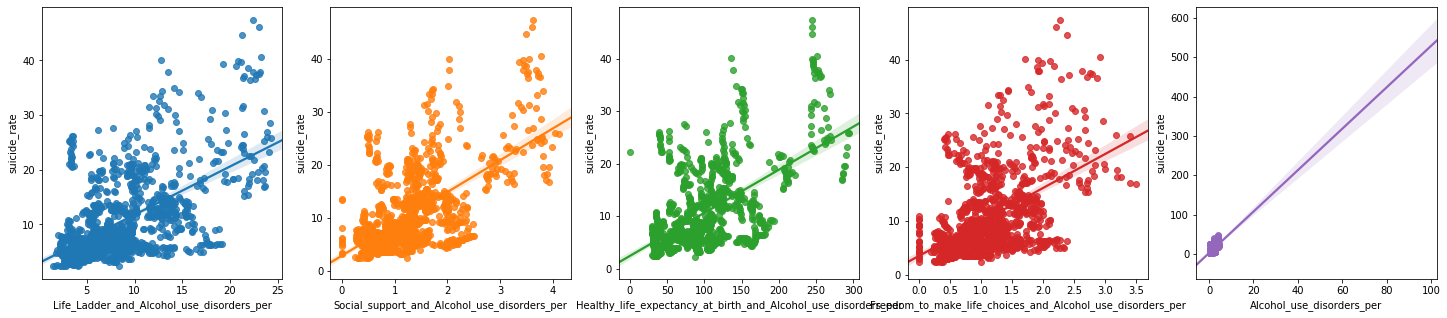

In [226]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))
for idx, ax in enumerate(axes):
    sns.regplot(x=alk_df1.iloc[:,1+idx], y='suicide_rate', data=alk_df1, ax=ax)

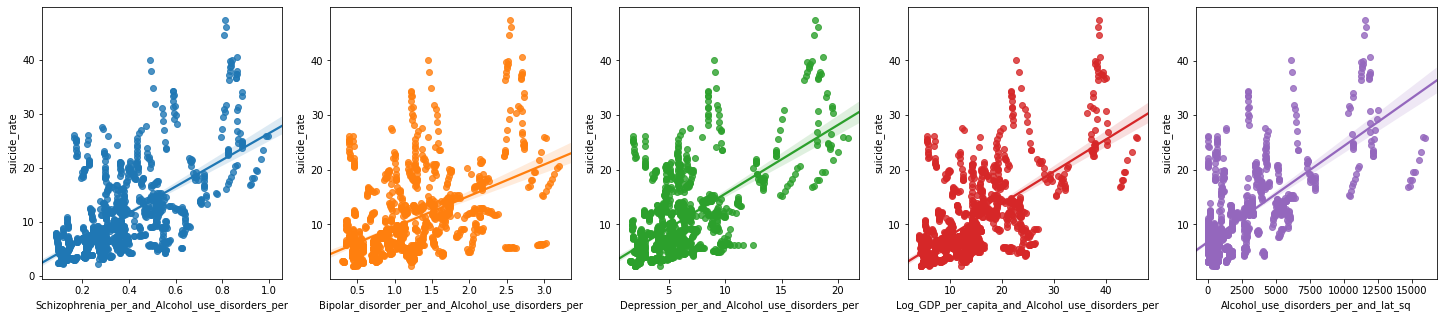

In [227]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))
for idx, ax in enumerate(axes):
    sns.regplot(x=alk_df2.iloc[:,1+idx], y='suicide_rate', data=alk_df2, ax=ax)

In [117]:
### Load files for geopandas ###
df_su = pd.read_csv('suicide_rates.csv') # 2005-2016, from Global Health Data Exchange from WHO
shapefile = 'ne_110m_admin_0_countries.shp' # https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

In [118]:
### Prep data for geopandas ###
df_su = df_su[['location_name', 'year', 'val']]
df_su = df_su.rename({'location_name': 'country', 'val': 'suicide_rate'}, axis=1)
df_su = df_su.groupby('country').mean().drop(columns='year').reset_index()

In [119]:
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [162]:
### Change USA, Russia, Czech Republic, Cote d'Ivoire, Congo, and Tanzania to match natural earth names ###
df_su.loc[df_su['country'] == 'United States'] # Index: 185
df_su.loc[df_su['country'] == 'Russian Federation'] # Index: 141
df_su.loc[df_su['country'] == 'Tanzania'] # Index: 170
df_su.loc[df_su['country'] == 'Czech Republic'] # Index: 45
df_su.loc[df_su['country'] == 'Congo'] # Index: 39
df_su.loc[df_su['country'] == 'Serbia'] # Index: 149
df_su.loc[df_su['country'] == "Cote d'Ivoire"] # Index: 41

df_su.at[185, 'country'] = 'United States of America'
df_su.at[141, 'country'] = 'Russia'
df_su.at[170, 'country'] = 'United Republic of Tanzania'
df_su.at[45, 'country'] = 'Czechia'
df_su.at[39, 'country'] = 'Republic of the Congo'
df_su.at[149, 'country'] = 'Republic of Serbia'
df_su.at[149, 'country'] = 'Ivory Coast'

In [163]:
merged = gdf.merge(df_su, on='country')

In [164]:
#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [165]:
### Nearly all code taken from https://github.com/CrazyDaffodils/Interactive-Choropleth-Map-Using-Python ###

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40)
#Define custom tick labels for color bar.
tick_labels = {'0': '0', '5': '5', '10':'10', '15':'15', '20':'20', '25':'25', '30':'30','35':'35', '40': '>40'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Mean Suicide Rates by Country', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'suicide_rate', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...